In [1]:
import itertools
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time

from scipy.stats import binom, norm
from math import comb

In [2]:
K_true = 3
M_true = 4

R_true = np.array([[0.1, 0.3, 0.4, 0.2],
                   [0.2, 0.6, 0.1, 0.1],
                   [0.5, 0.2, 0.1, 0.2]])

P_true = np.array([0.25, 0.35, 0.4])
Q_true = np.array([0.1, 0.2, 0.6])


X_param_true = np.array([[-5, 1.5],
                         [2, 1.6],
                         [7, 2.2]])


Y_param_true = np.array([[[-1, 0.5], [5, 1.5], [9, 0.5], [12, 0.8]],
                         [[-2, 0.5], [8, 0.9], [12, 0.8], [16, 0.8]],
                         [[-2, 0.5], [7, 0.9], [13, 0.8], [17, 0.8]]])

In [3]:
# K_true = 2
# M_true = 4

# R_true = np.array([[0.1, 0.3, 0.4, 0.2],
#                    [0.2, 0.6, 0.1, 0.1]])

# P_true = np.array([0.25, 0.75])
# Q_true = np.array([0.5, 0.8])


# X_param_true = np.array([[-5, 1.5],
#                          [2, 1.6]])


# Y_param_true = np.array([[[-1, 0.5], [5, 1.5], [9, 0.5], [12, 0.8]],
#                          [[-2, 0.5], [8, 0.9], [12, 1.1], [16, 1.2]]])

In [4]:
def generate_data(R, P, Q, X_param, Y_param):
    K = P.shape[0]
    M = R.shape[1]
    
    # Choose idx of mixture on X
    i = np.random.choice(K, p=P)

    # Choose amount of latent variables in this mixture
    eta = 1 + np.random.binomial(n=M-1, p=Q[i])

    # Choose subset of size eta
    idx_subset = np.random.choice(M, replace=False, size=eta, p=R[i])

    # Choose mixture latent variable
    l = np.random.choice(a=idx_subset)

    x = np.random.normal(X_param[i][0], np.sqrt(X_param[i][1]))
    y = np.random.normal(Y_param[i, l][0], np.sqrt(Y_param[i, l][1]))

    return x, y, i*M + l

In [5]:
def generate_dataset(n_samples, R, P, Q, X_param, Y_param, random_state=42):
    np.random.seed(random_state)

    data = []
    labels = []

    for _ in range(n_samples):
        x, y, label = generate_data(R, P, Q, X_param, Y_param)
        data.append(np.array([x, y]))
        labels.append(label)

    return np.array(data), np.array(labels)

In [6]:
# Update R x2

# for i in range(self.K):
#     k_x = 0
    
#     c = np.zeros(self.M)
#     a = np.zeros(self.M)

#     for l in range(self.M):
#         for j in range(self.M):
#             factor = 0
#             denominator = comb(self.M, j)

#             for s in self.bits_cache[j]:
#                 indicator = l in s
#                 factor += indicator * np.prod(self.R[i][[s]]) / self.R[i, l]
            
#             factor /= denominator

#             a[l] += factor * np.sum(responsibilities[:, i, j, :, :])

#             for s in self.bits_cache[j]:
#                 s_idx = np.sum(2 ** np.array(s)) - 1
#                 indicator = l in s

#                 c[l] += np.sum(responsibilities[:, i, j, s_idx, :]) * indicator + np.sum(responsibilities[:, i, j, s_idx, l])
                
#         k_x += c[l]


#     r_sum = 0
#     for l in range(self.M):
#         # print("b:", -4*a[l]*c[l])
#         self.R[i, l] = (-k_x + np.sqrt(k_x**2 + 4*a[l]*c[l])) / (2 * a[l])
#         r_sum += self.R[i, l]
    
#     self.R[i] += (1 - r_sum) / self.M

In [7]:
# class EMModel:
#     def __init__(self):
#         self.bits_cache = None
#         self.denominator_pi = None

#         self.K = None
#         self.M = None

#         self.R = None
#         self.P = None
#         # Q - mmatrix
#         self.Q = None
#         self.X_param = None
#         self.Y_param = None

#         self.current_likelihood_ = None

#     def fit(self, data, R, P, Q, X_param, Y_param, epochs):
#         n = data.shape[0]
#         self.K = P.shape[0]
#         self.M = R.shape[1]
#         self.R = np.copy(R)
#         self.P = np.copy(P)
#         self.Q = np.copy(Q)
#         self.X_param = np.copy(X_param)
#         self.Y_param = np.copy(Y_param)

#         self.bits_cache = [list(itertools.combinations(range(self.M), j)) for j in range(1, self.M + 1)]
        
#         resp_shape = (n, self.K, self.M, 2**self.M - 1, self.M)
#         responsibilities = np.zeros(resp_shape)

#         start_time = time.time()
        
#         self.current_likelihood_ = np.zeros(epochs)
#         for epoch in range(epochs):
#             print("Epoch:", epoch)
#             # E-Step
#             # Calculate responsibilities 

#             for t, (x, y) in enumerate(data):
#                 for i in range(self.K):
#                     for j in range(self.M):
#                         for s in self.bits_cache[j]:
#                             s_idx = np.sum(2 ** np.array(s)) - 1
#                             for l in s:
#                                 responsibilities[t, i, j, s_idx, l] = self.calculate_responsb_(x, y, i, j, s, l)

#                 s_t = np.sum(responsibilities[t, :, :, :, :])
#                 self.current_likelihood_[epoch] += np.log(s_t)
#                 responsibilities[t, :, :, :, :] /= s_t



#             print("E-Step done")
#             end_time = time.time()
#             print(f"Time elapsed: {end_time - start_time} seconds")
             
#             # M-Step
#             # Update parameters

#             # Update P
#             for i in range(self.K):
#                 self.P[i] = np.sum(responsibilities[:, i, :, :, :]) / n

#             # Update Q
#             for i in range(self.K):
#                 for j in range(self.M):
#                     res = 0
#                     for s in self.bits_cache[j]:
#                         s_idx = np.sum(2 ** np.array(s)) - 1
#                         for l in s:
#                             res += np.sum(responsibilities[:, i, j, s_idx, l])
                
#                     self.Q[i, j] = res / np.sum(responsibilities[:, i, :, :, :])

            
#             # Update R
#             for i in range(self.K):
#                 for l in range(self.M):
#                     res = 0

#                     for t in range(n):
#                         for j in range(self.M):
#                             for s in self.bits_cache[j]:
#                                 s_idx = np.sum(2 ** np.array(s)) - 1
#                                 indicator = l in s
#                                 res += responsibilities[t, i, j, s_idx, l] + indicator * np.sum(responsibilities[t, i, j, s_idx, :])
                
#                     self.R[i, l] = res
                
#                 self.R[i] /= np.sum(self.R[i])
            
#             # Update R x2

#             # for i in range(self.K):
#             #     k_x = 0
                
#             #     c = np.zeros(self.M)
#             #     a = np.zeros(self.M)

#             #     for l in range(self.M):
#             #         for j in range(self.M):
#             #             factor = 0
#             #             denominator = comb(self.M, j)

#             #             for s in self.bits_cache[j]:
#             #                 indicator = l in s
#             #                 factor += indicator * np.prod(self.R[i][[s]]) / self.R[i, l]
                        
#             #             factor /= denominator

#             #             a[l] += factor * np.sum(responsibilities[:, i, j, :, :])

#             #             for s in self.bits_cache[j]:
#             #                 s_idx = np.sum(2 ** np.array(s)) - 1
#             #                 indicator = l in s

#             #                 c[l] += np.sum(responsibilities[:, i, j, s_idx, :]) * indicator + np.sum(responsibilities[:, i, j, s_idx, l])
                            
#             #         k_x += c[l]


#             #     r_sum = 0
#             #     for l in range(self.M):
#             #         # print("b:", -4*a[l]*c[l])
#             #         self.R[i, l] = (-k_x + np.sqrt(k_x**2 + 4*a[l]*c[l])) / (2 * a[l])
#             #         r_sum += self.R[i, l]
                
#             #     self.R[i] += (1 - r_sum) / self.M
                
            
#             # Update mean for X
#             for i in range(self.K):
#                 res = 0
#                 for t in range(n):
#                     res += np.sum(responsibilities[t, i, :, :, :]) * data[t, 0]
#                 self.X_param[i, 0] = res / np.sum(responsibilities[:, i, :, :, :])
            
#             # Update variance for X
#             for i in range(self.K):
#                 res = 0
#                 for t in range(n):
#                     res += np.sum(responsibilities[t, i, :, :, :]) * (data[t, 0] - self.X_param[i, 0])**2
#                 self.X_param[i, 1] = res / np.sum(responsibilities[:, i, :, :, :])
            
            
#             # Update mean for Y
#             for i in range(self.K):
#                 for l in range(self.M):
#                     res = 0
#                     for t in range(n):
#                         res += data[t, 1] * np.sum(responsibilities[t, i, :, :, l])

#                     self.Y_param[i, l, 0] = res / np.sum(responsibilities[:, i, :, :, l])
            
#             # Update variance for Y
#             for i in range(self.K):
#                 for l in range(self.M):
#                     res = 0
#                     for t in range(n):
#                         res += np.sum(responsibilities[t, i, :, :, l]) * (data[t, 1] - self.Y_param[i, l, 0])**2

#                     self.Y_param[i, l, 1] = res / np.sum(responsibilities[:, i, :, :, l])
            
#             print("M-step done")

#             print("Current log likelihood:", self.current_likelihood_[epoch])
#             print("P:\n", self.P)
#             print("Q:\n", self.Q)
#             print("R:\n", self.R)
#             print("X_param\n", self.X_param)
#             print("Y_param\n", self.Y_param)

        
#         return responsibilities
        
    
#     def set_prob_(self, i, j, s):
#         denominator = 0
#         # Retrive all bits with sum = j
#         for bits in self.bits_cache[j]:
#             denominator += np.prod(self.R[i][[bits]])

#         # s - indexes that coresspond to 1's bit
#         return np.prod(self.R[i][[s]]) / denominator


#     def calculate_pi_(self, i, j, s, l):
#         s_l = l in s
#         return self.P[i] * self.Q[i, j] * self.set_prob_(i, j, s)  * self.R[i, l] / np.sum(self.R[i][[s]])


#     def calculate_responsb_(self, x, y, i, j, s, l):
#         return self.calculate_pi_(i, j, s, l) * norm.pdf(x, loc=self.X_param[i][0], scale=np.sqrt(self.X_param[i][1])) * \
#         norm.pdf(y, loc=self.Y_param[i,l][0], scale=np.sqrt(self.Y_param[i,l][1]))

In [8]:
class EMModel:
    def __init__(self):
        self.bits_cache = None
        self.denominator_pi = None

        self.K = None
        self.M = None

        self.R = None
        self.P = None
        # Q - mmatrix
        self.Q = None
        self.X_param = None
        self.Y_param = None

        self.current_likelihood_ = None

    def fit(self, data, R, P, Q, X_param, Y_param, epochs):
        n = data.shape[0]
        self.K = P.shape[0]
        self.M = R.shape[1]
        self.R = np.copy(R)
        self.P = np.copy(P)
        self.Q = np.copy(Q)
        self.X_param = np.copy(X_param)
        self.Y_param = np.copy(Y_param)

        self.bits_cache = [list(itertools.combinations(range(self.M), j)) for j in range(1, self.M + 1)]
        
        resp_shape = (n, self.K, self.M, 2**self.M - 1, self.M)
        responsibilities = np.zeros(resp_shape)

        start_time = time.time()

        self.current_likelihood_ = np.zeros(epochs)
        for epoch in range(epochs):
            print("Epoch:", epoch)
            # E-Step
            # Calculate responsibilities 

            for t, (x, y) in enumerate(data):
                for i in range(self.K):
                    for j in range(0, self.M):
                        for s in self.bits_cache[j]:
                            s_idx = np.sum(2 ** np.array(s)) - 1
                            
                            for l in s:
                                responsibilities[t, i, j, s_idx, l] = self.calculate_responsb_(x, y, i, j, s, l)
                

                s_t = np.sum(responsibilities[t, :, :, :, :])
                responsibilities[t, :, :, :, :] /= s_t
                self.current_likelihood_[epoch] += np.log(s_t)
            
            print("E-Step done")
            end_time = time.time()
            print(f"Time elapsed: {end_time - start_time} seconds")
             
            # M-Step
            # Update parameters

            # Update P
            for i in range(self.K):
                self.P[i] = np.sum(responsibilities[:, i, :, :, :]) / n

            # Update Q
            for i in range(self.K):
                for j in range(self.M):
                    res = 0
                    for s in self.bits_cache[j]:
                        s_idx = np.sum(2 ** np.array(s)) - 1
                        for l in s:
                            res += np.sum(responsibilities[:, i, j, s_idx, l])
                
                    self.Q[i, j] = res / np.sum(responsibilities[:, i, :, :, :])

            
            # Update R
            for i in range(self.K):
                for l in range(self.M):
                    res = 0

                    for t in range(n):
                        for j in range(self.M):
                            for s in self.bits_cache[j]:
                                s_idx = np.sum(2 ** np.array(s)) - 1
                                indicator = l in s
                                res += responsibilities[t, i, j, s_idx, l] + indicator * np.sum(responsibilities[t, i, j, s_idx, :])
                
                    self.R[i, l] = res
                
                self.R[i] /= np.sum(self.R[i])


            # # Update R

            # for i in range(self.K):
            #     k_x = 0
                
            #     c = np.zeros(self.M)
            #     a = np.zeros(self.M)

            #     for l in range(self.M):
            #         for j in range(self.M):
            #             factor = 0
            #             denominator = 0

            #             for s in self.bits_cache[j]:
            #                 indicator = l in s
            #                 factor += indicator * np.prod(self.R[i][[s]]) / self.R[i, l]
            #                 denominator += np.prod(self.R[i][[s]])
                        
            #             factor /= denominator

            #             a[l] += factor * np.sum(responsibilities[:, i, j, :, :])

            #             for s in self.bits_cache[j]:
            #                 s_idx = np.sum(2 ** np.array(s)) - 1
            #                 indicator = l in s

            #                 c[l] += np.sum(responsibilities[:, i, j, s_idx, l]) + indicator * np.sum(responsibilities[:, i, j, s_idx, :])
                            
            #         k_x += c[l]


            #     r_sum = 0
            #     for l in range(self.M):
            #         # print("b:", -4*a[l]*c[l])
            #         self.R[i, l] = (-k_x + np.sqrt(k_x**2 + 4*a[l]*c[l])) / (2 * a[l])
            #         r_sum += self.R[i, l]
                
            #     self.R[i] += (1 - r_sum) / self.M

            
            # Update mean for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :, :]) * data[t, 0]
                self.X_param[i, 0] = res / np.sum(responsibilities[:, i, :, :, :])
            
            # Update variance for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :, :]) * (data[t, 0] - self.X_param[i, 0])**2
                self.X_param[i, 1] = res / np.sum(responsibilities[:, i, :, :, :])
            
            
            # Update mean for Y
            for i in range(self.K):
                for l in range(self.M):
                    res = 0
                    for t in range(n):
                        res += data[t, 1] * np.sum(responsibilities[t, i, :, :, l])

                    self.Y_param[i, l, 0] = res / np.sum(responsibilities[:, i, :, :, l])
            
            # Update variance for Y
            for i in range(self.K):
                for l in range(self.M):
                    max_val = -np.inf

                    res = 0
                    for t in range(n):
                        if np.sum(responsibilities[t, i, :, :, l]) > max_val:
                            max_val = np.sum(responsibilities[t, i, :, :, l])

                        res += np.sum(responsibilities[t, i, :, :, l]) * (data[t, 1] - self.Y_param[i, l, 0])**2

                    self.Y_param[i, l, 1] = (1/self.K + res) / (6 + np.sum(responsibilities[:, i, :, :, l]))
            
            print("M-step done")

            print("Current log likelihood:", self.current_likelihood_[epoch])
            print("P:\n", self.P)
            print("Q:\n", self.Q)
            print("R:\n", self.R)
            print("X_param\n", self.X_param)
            print("Y_param\n", self.Y_param)
        
    
    def set_prob_(self, i, j, s):
        denominator = 0
        # Retrive all bits with sum = j
        for bits in self.bits_cache[j]:
            denominator += np.prod(self.R[i][[bits]])

        # s - indexes that coresspond to 1's bit
        return np.prod(self.R[i][[s]]) / denominator


    def calculate_pi_(self, i, j, s, l):
        s_l = l in s
        return self.P[i] * self.Q[i, j] * self.set_prob_(i, j, s) * s_l * self.R[i, l] / np.sum(self.R[i][[s]])


    def calculate_responsb_(self, x, y, i, j, s, l):
        return self.calculate_pi_(i, j, s, l) * \
            norm.pdf(x, loc=self.X_param[i,0], scale=np.sqrt(self.X_param[i,1])) * \
            norm.pdf(y, loc=self.Y_param[i,l][0], scale=np.sqrt(self.Y_param[i,l][1]))

In [9]:
def generate_est_parameters(data, random_state):
    np.random.seed(random_state)

    # Estimate R
    R_est = np.ones(shape=(K_true, M_true)) / M_true
    noise = np.random.dirichlet(np.ones(M_true), size=K_true)
    R_est += noise * 0.05
    R_est /= np.sum(R_est, axis=1).reshape(-1, 1)


    # Estimate P
    P_est = np.full(K_true, 1/K_true)
    noise = np.random.dirichlet(np.ones(K_true))
    P_est += noise * 0.05
    P_est /= np.sum(P_est)

    # Estimate Q
    # Q_est = np.zeros(shape=(K_true, M_true))
    # for i in range(K_true):
    #     for j in range(M_true):
    #         Q_est[i, j] = binom.pmf(k=j, n=M_true-1, p=0.5)
    
    # Estimate Q
    Q_est = np.ones(shape=(K_true, M_true)) / M_true
    noise = np.random.dirichlet(np.ones(M_true), size=K_true)
    Q_est += noise * 0.05
    Q_est /= np.sum(Q_est, axis=1).reshape(-1, 1)

    
    # Estimate X, Y
    X_param_est = np.zeros((K_true, 2))
    Y_param_est = np.zeros((K_true, M_true, 2))

    min_x = np.min(data[:, 0])
    max_x = np.max(data[:, 0])
    intervals = np.linspace(min_x, max_x, K_true + 1)

    for i in range(0, K_true):
        X_param_est[i][0] = np.random.uniform(intervals[i], intervals[i+1])
        X_param_est[i][1] = np.random.uniform(0, (intervals[i+1] - intervals[i])/6)
    
    min_y = np.min(data[:, 1])
    max_y = np.max(data[:, 1])

    intervals = np.linspace(min_y, max_y, M_true + 1)

    for i in range(0, K_true):
        for j in range(0, M_true):
            Y_param_est[i, j, 0] = np.random.uniform(intervals[j], intervals[j+1])
            Y_param_est[i, j, 1] = np.random.uniform(0, (intervals[j+1] - intervals[j])/6)

    return R_est, P_est, Q_est, X_param_est, Y_param_est

In [10]:
def q_to_matrix(Q):
    # Suppose Q is 1d array

    Q_matrix = np.zeros((K_true, M_true))
    
    for i in range(0, K_true):
        for j in range(1, M_true + 1):
            Q_matrix[i, j-1] = binom.pmf(k=j-1, n=M_true-1, p=Q[i])
    
    return Q_matrix

In [11]:
data, labels = generate_dataset(500, R_true, P_true, Q_true, X_param_true, Y_param_true)

In [12]:
R_est, P_est, Q_est, X_param_est, Y_param_est = generate_est_parameters(data, 15)

In [13]:
P_est

array([0.32970847, 0.33689972, 0.3333918 ])

In [14]:
R_est

array([[0.2728179 , 0.24171782, 0.23912256, 0.24634173],
       [0.24659182, 0.2580095 , 0.24772676, 0.24767192],
       [0.23985341, 0.24236182, 0.2751384 , 0.24264637]])

In [15]:
Q_est

array([[0.26027926, 0.25526799, 0.2425835 , 0.24186925],
       [0.23932514, 0.27404927, 0.24066296, 0.24596264],
       [0.24508304, 0.24585991, 0.2696991 , 0.23935795]])

In [16]:
X_param_est

array([[-5.31986888,  0.14873232],
       [ 1.44615846,  0.31415832],
       [ 7.74656234,  0.69937582]])

In [17]:
Y_param_est

array([[[-1.7027441 ,  0.60031   ],
        [ 5.68805222,  0.40467376],
        [10.08483532,  0.37618976],
        [15.88317728,  0.07676233]],

       [[-3.48048118,  0.0754758 ],
        [ 5.99418918,  0.02809614],
        [10.64128575,  0.12779988],
        [13.71267986,  0.61618046]],

       [[-1.23058878,  0.93908286],
        [ 3.87874139,  0.18830172],
        [11.70824731,  0.33830153],
        [17.99246631,  0.76293893]]])

In [18]:
model = EMModel()
res = model.fit(data, R_est, P_est, Q_est, X_param_est, Y_param_est, epochs=25)

Epoch: 0
E-Step done
Time elapsed: 12.298617124557495 seconds
M-step done
Current log likelihood: -6939.857921526254
P:
 [0.2794496  0.29677414 0.42377626]
Q:
 [[0.26117107 0.25404251 0.24208843 0.24269799]
 [0.23947628 0.27382335 0.24058239 0.24611797]
 [0.24544015 0.24537426 0.26947887 0.23970672]]
R:
 [[0.20051198 0.29311131 0.36539311 0.1409836 ]
 [0.20648213 0.20318027 0.2996588  0.29067881]
 [0.32379307 0.19719287 0.23499563 0.24401843]]
X_param
 [[-5.03646556  1.46522946]
 [ 1.67474566  1.66556679]
 [ 6.68123288  3.50637998]]
Y_param
 [[[-1.05652253  0.70841181]
  [ 5.18574166  1.35851391]
  [10.32906902  2.50031631]
  [14.00781607  0.05407257]]

 [[-2.23472022  0.15192376]
  [ 6.79280005  0.15696303]
  [ 9.12511615  0.97593823]
  [12.07573279 11.10229474]]

 [[-1.77764898  0.42161654]
  [ 6.67228051  0.19555573]
  [10.54935477  5.5477006 ]
  [16.96902741  0.68916036]]]
Epoch: 1
E-Step done
Time elapsed: 25.76629948616028 seconds
M-step done
Current log likelihood: -2726.6198517

In [19]:
model.current_likelihood_

array([-6939.85792153, -2726.6198517 , -2688.9226556 , -2672.48796899,
       -2666.07783301, -2662.19058306, -2657.79911817, -2651.21018318,
       -2647.61840798, -2644.71261893, -2641.86049691, -2639.55334988,
       -2637.51489602, -2635.43608555, -2633.31983335, -2631.21737992,
       -2629.53304924, -2628.30157164, -2627.39914705, -2626.77228524,
       -2626.35959981, -2626.10150139, -2625.95149056, -2625.87093864,
       -2625.82983688])

In [20]:
y_vals = model.current_likelihood_

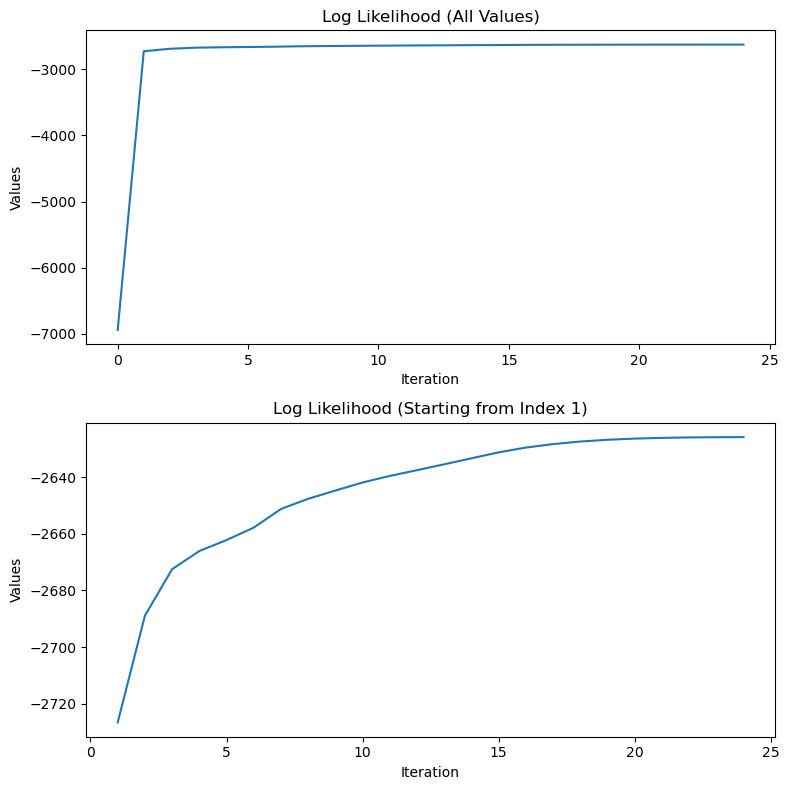

In [21]:
fig, axis = plt.subplots(2, 1, figsize=(8, 8))

ax = axis[0]

ax.plot(np.arange(len(y_vals)), y_vals)
ax.set_title('Log Likelihood (All Values)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')


ax = axis[1]
ax.plot(np.arange(1, len(y_vals)), y_vals[1:])
ax.set_title('Log Likelihood (Starting from Index 1)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')

plt.tight_layout();

In [22]:
P_true

array([0.25, 0.35, 0.4 ])

In [23]:
model.P

array([0.28205297, 0.33876153, 0.3791855 ])

In [24]:
res = q_to_matrix(Q_true)
res

array([[0.729, 0.243, 0.027, 0.001],
       [0.512, 0.384, 0.096, 0.008],
       [0.064, 0.288, 0.432, 0.216]])

In [25]:
model.Q

array([[0.19620509, 0.3489979 , 0.27246985, 0.18232716],
       [0.23407728, 0.28188822, 0.24346526, 0.24056924],
       [0.2253392 , 0.2731377 , 0.28144779, 0.22007531]])

In [26]:
R_true

array([[0.1, 0.3, 0.4, 0.2],
       [0.2, 0.6, 0.1, 0.1],
       [0.5, 0.2, 0.1, 0.2]])

In [27]:
model.R

array([[0.18813537, 0.2785509 , 0.28588005, 0.24743369],
       [0.246107  , 0.23829037, 0.24865999, 0.26694264],
       [0.30759956, 0.24429259, 0.19184125, 0.2562666 ]])

In [28]:
np.sum(model.R, axis=1)

array([1., 1., 1.])

In [29]:
X_param_true

array([[-5. ,  1.5],
       [ 2. ,  1.6],
       [ 7. ,  2.2]])

In [30]:
model.X_param

array([[-5.00887178,  1.53662494],
       [ 1.91863997,  1.90059245],
       [ 7.07763488,  2.19494904]])

In [31]:
Y_param_true

array([[[-1. ,  0.5],
        [ 5. ,  1.5],
        [ 9. ,  0.5],
        [12. ,  0.8]],

       [[-2. ,  0.5],
        [ 8. ,  0.9],
        [12. ,  0.8],
        [16. ,  0.8]],

       [[-2. ,  0.5],
        [ 7. ,  0.9],
        [13. ,  0.8],
        [17. ,  0.8]]])

In [32]:
model.Y_param

array([[[-1.15064479,  0.47363636],
        [ 4.81535973,  0.75051614],
        [ 8.79656378,  0.53930877],
        [11.94579966,  0.61400951]],

       [[-1.86853505,  0.31304491],
        [ 7.29092582,  0.36033557],
        [ 8.55431322,  0.23110825],
        [13.07335706,  5.708171  ]],

       [[-1.86824951,  0.43674297],
        [ 7.12544906,  0.46689529],
        [12.85857639,  0.65813572],
        [17.03175725,  0.57972032]]])